# CAT Vs Dog

## 4. CNN시각화

### 4.1. 중간층의 출력을 시각화하기

- 기존 모델 로딩

In [1]:
from tensorflow.keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

- 테스트 이미지

In [2]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = 'data/cats_and_dogs/test/cats/cat.1700.jpg'
img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
print(img_tensor.shape)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(150, 150, 3)
(1, 150, 150, 3)


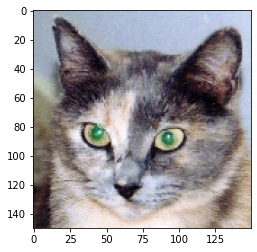

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img_tensor[0]);

- 상위 8개 층의 출력을 추출하는 모델 객체 만들기

In [4]:
from tensorflow.keras.models import Model
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activation_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0     

In [5]:
activations = activation_model.predict(img_tensor)

In [6]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


- 첫번째 층 : 13번째 채널 시각화

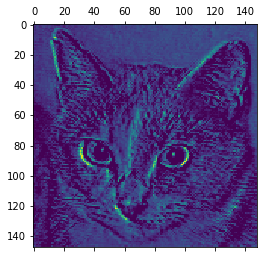

In [7]:
plt.matshow(first_layer_activation[0, :, :, 12], cmap='viridis')

- 첫번째 층 : 2번째 채널 시각화

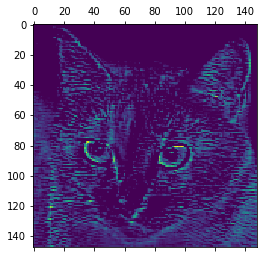

In [8]:
plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')

- 모든 활성화에 있는 채널 시각화

<ipython-input-9-f5441e6d4e72>:18: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


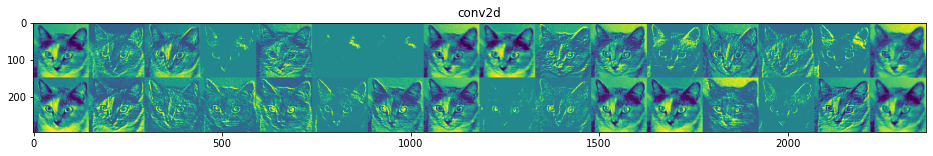

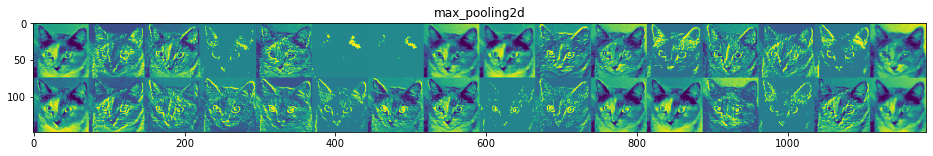

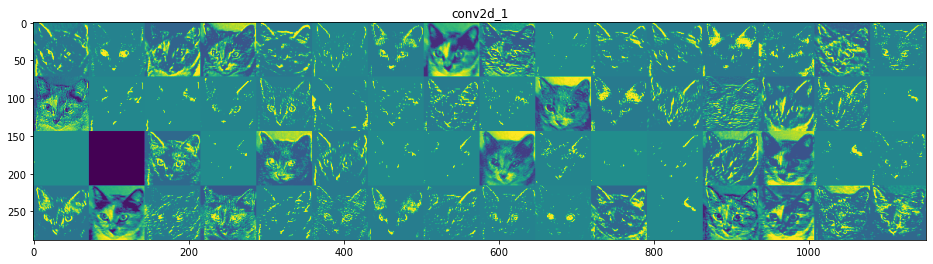

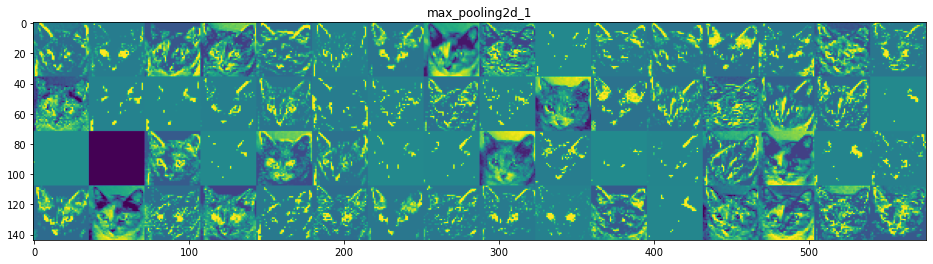

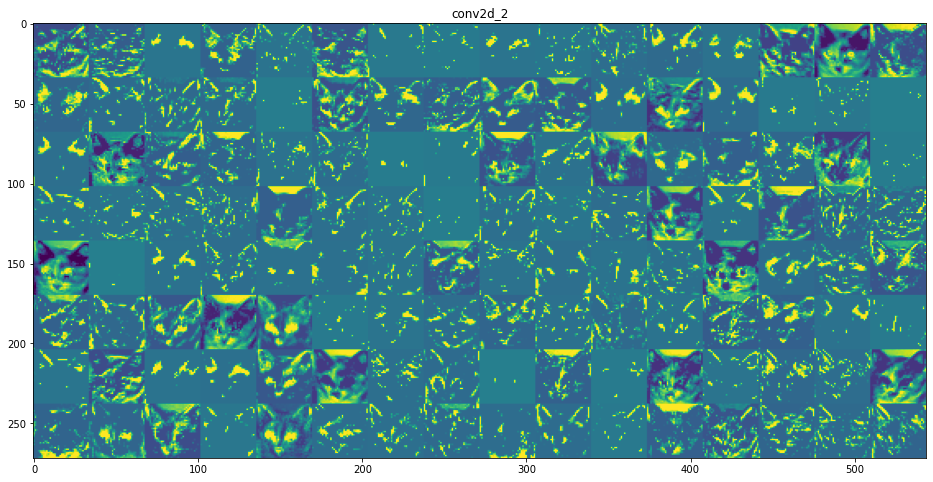

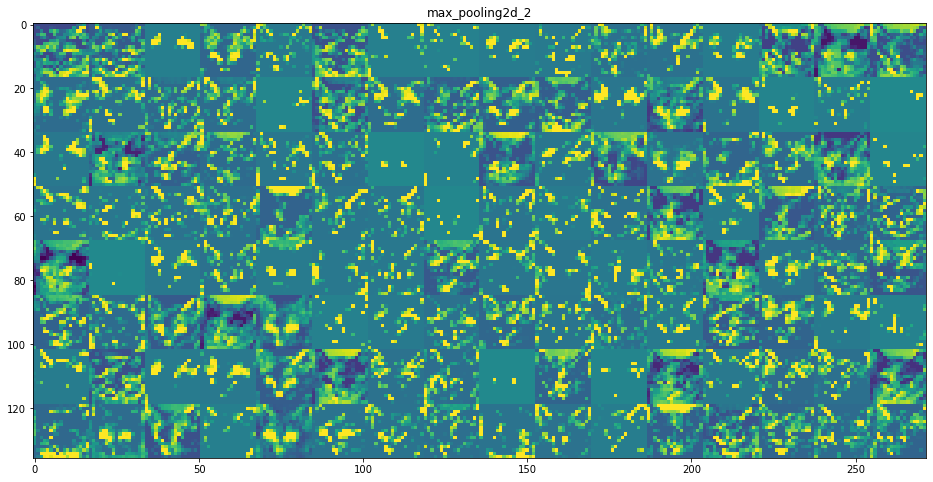

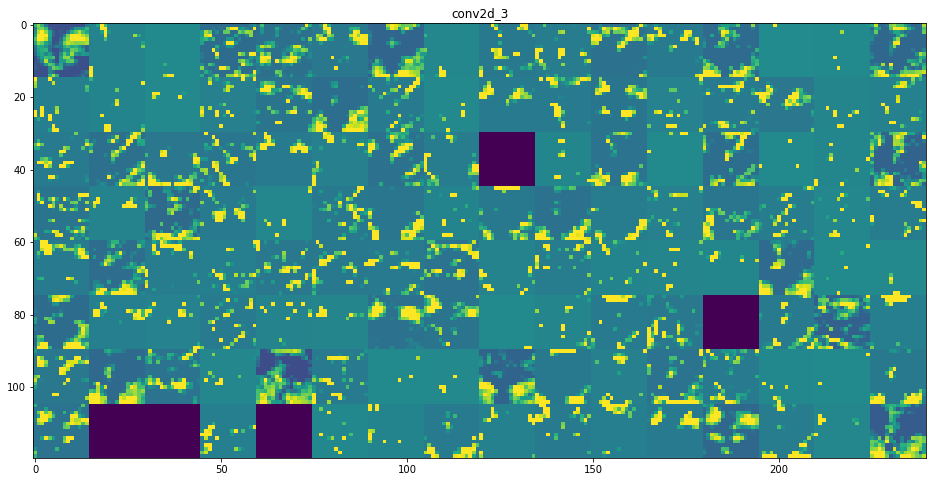

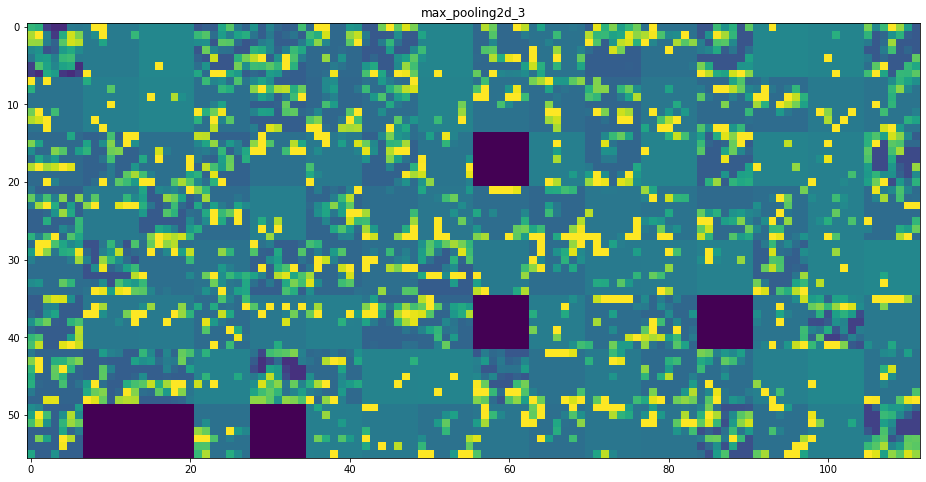

In [9]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### 4.2. Class Activation Map (CAM)

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

In [11]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'data/creative_commons_elephant.jpg'

img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
print(x.shape)

x = np.expand_dims(x, axis=0)
print(x.shape)
x = preprocess_input(x)
print(x.shape)

(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


In [13]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=5)[0])

Predicted: [('n02504458', 'African_elephant', 0.90988594), ('n01871265', 'tusker', 0.085724816), ('n02504013', 'Indian_elephant', 0.00434713), ('n02408429', 'water_buffalo', 4.051109e-05), ('n02397096', 'warthog', 1.3894321e-06)]


In [14]:
np.argmax(preds[0])

386

In [15]:
preds[0][386]

0.90988594

In [16]:
# 옜날 코드 실행안됌 
from tensorflow.keras import backend as K
african_elephant_output = model.output[:, 386]

last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

In [17]:
import tensorflow as tf
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [18]:
heatmap = make_gradcam_heatmap(x, model, 'block5_conv3')

In [19]:
heatmap.shape

(14, 14)

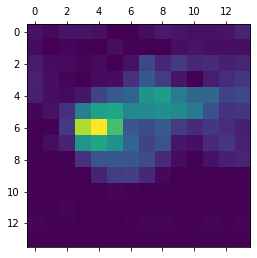

In [20]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [21]:
import cv2
img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('elephant_cam.jpg', superimposed_img)

True